<a href="https://colab.research.google.com/github/christianlozano99/ChristianLozano/blob/master/TensorFlow-CovidLungs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Christian Lozano Assigment 5 Spring 2021**


## **Loading Libraries and GPU**

In [ ]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import pathlib
import numpy as np
import os
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image



from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17174188639324771534
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4949437312
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14161451616487442372
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


## **Loading in the csv files for train and test**

In [ ]:
trainDF = pd.read_csv('/Users/Christian Lozano/Desktop/Assignment 5/assignment5_training_data_metadata.csv')
testDF = pd.read_csv('/Users/Christian Lozano/Desktop/Assignment 5/assignment5_test_data_metadata.csv')


print( trainDF.groupby('type').nunique())

                  id  image_name  label  cause
type                                          
Stress-Smoking     2           2      1      1
Virus           1407        1407      1      2
bacteria        2535        2535      1      1


### **Fixing Missing Data**
Dataframe was left empty on normal lungs so I replaced the empty spots with none since there is no cause or type. 

In [ ]:
trainDF['cause'] = trainDF['cause'].fillna('none')
trainDF['type'] = trainDF['type'].fillna('none')
print(trainDF.isnull().sum().sum())
print(testDF.isnull().sum().sum())
print(pd.unique(trainDF['type']))
trainDF

### **Translating Types to Ints**
We need to change the type to numbers 1 = normal, 2 = virus, 3 = bactiria, 4 = stress smoking

In [ ]:
 trainDF.type = trainDF.type.map( {'none':1 , 'Virus':2, 'bacteria':3, 'Stress-Smoking':4})

print( trainDF.groupby('type').nunique())
trainDF

### **Setting up Classes for Tensor**
It has an if statment with false passed to it because I did it once and it casued errors everytime I ran my code over again since its already moved.

In [ ]:
import shutil

numnorm = 0
numstress = 0
numbac = 0
numvirus = 0
if(False):
  for value in range(len(trainDF.index)):
    if(trainDF['type'][value] == 1 ): #1 is normal
      numnorm += 1
      shutil.move('/Users/Christian Lozano/Desktop/Assignment 5/train/train/'+trainDF['image_name'][value] , '/Users/Christian Lozano/Desktop/Assignment 5/train/Normal/'+trainDF['image_name'][value])

    elif(trainDF['type'][value] == 2):#2 is Virus
      numvirus += 1
      shutil.move('/Users/Christian Lozano/Desktop/Assignment 5/train/train/'+trainDF['image_name'][value] , '/Users/Christian Lozano/Desktop/Assignment 5/train/Virus/'+trainDF['image_name'][value])

    elif(trainDF['type'][value] == 3):#3 is bactira
      numbac += 1
      shutil.move('/Users/Christian Lozano/Desktop/Assignment 5/train/train/'+trainDF['image_name'][value] , '/Users/Christian Lozano/Desktop/Assignment 5/train/Bacteria/'+trainDF['image_name'][value])
    
    elif(trainDF['type'][value] == 4):#4 is stress smoking
      numstress += 1
      shutil.move('/Users/Christian Lozano/Desktop/Assignment 5/train/train/'+trainDF['image_name'][value] , '/Users/Christian Lozano/Desktop/Assignment 5/train/Stress-Smoking/'+trainDF['image_name'][value])
    
  print(numnorm)
  print(numvirus)
  print(numbac)
  print(numstress)


### **Making the Tensor to feed into the CNN**

In [ ]:
trainImageDir = '/Users/Christian Lozano/Desktop/Assignment 5/train'
testImageDir = '/Users/Christian Lozano/Desktop/Assignment 5/test'

Traindata_dir = tf.keras.utils.get_file(origin ='/train', fname = trainImageDir)
Testdata_dir = tf.keras.utils.get_file(origin ='/test', fname = testImageDir)

batch_sizein = 32
TrainTensor = tf.keras.preprocessing.image_dataset_from_directory(Traindata_dir, image_size=(180, 180), batch_size=batch_sizein)
TestTensor =  tf.keras.preprocessing.image_dataset_from_directory(Testdata_dir, image_size=(180, 180), batch_size=batch_sizein)



Found 5286 files belonging to 4 classes.
Found 624 files belonging to 5 classes.


### **Validation Dataset**
Making a validation set based of 20% of the data to see how accurate I am.

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  Traindata_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(180, 180),
  batch_size=batch_sizein)

Found 5286 files belonging to 4 classes.
Using 1057 files for validation.


### **Example Images**
Wanted to see what some of the images looked like so far to know what kind of data augmentation I should use.

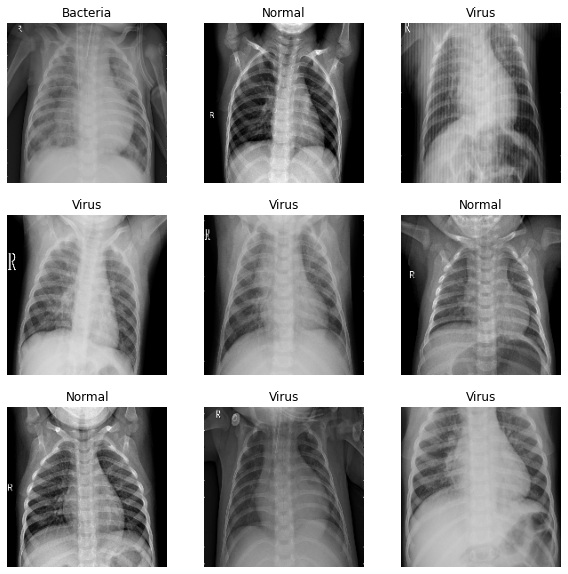

In [ ]:
import matplotlib.pyplot as plt
 
class_names = TrainTensor.class_names
plt.figure(figsize=(10, 10))
for images, labels in TrainTensor.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### **Setting up the CNN Model**
I used 3 data augmentation functions which were:

1.   **Random Rotation**
2.   **Random Translation**
3.   **Random Zoom**

I chose these based on the fact that some of the images seemed to have more zoom than others for instance some I can see the colar bone and some I cant.
Also some were angled a bit diffrently so I used a small rotation factor of 0.1, and finally I used random tranlsation because some of the images were more shifted to one side than the other so this would make the model not be affected by it.

In [ ]:
num_classes = 4

model = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.2, .3), width_factor=(-.2,.3), fill_mode='reflect', interpolation='nearest',seed=None,name=None, fill_value=0.0,),
  layers.experimental.preprocessing.RandomZoom(height_factor=(-0.2, .2), width_factor=(-.2,.2), fill_mode='reflect', interpolation='nearest',seed=None,name=None, fill_value=0.0,),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(batch_sizein, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(batch_sizein, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(batch_sizein, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(batch_sizein, activation='relu'),
  layers.Dense(num_classes)
])

### **Compiling the Model**

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

### **Fitting the Model**
I am fitting the model and testing for accuracies to see what will be the most effective and would not underfit or over fit my images.

In [ ]:
model.fit(
  TrainTensor,
  validation_data=val_ds,
  epochs=30
)

Epoch 1/30
166/166 [==============================] - 44s 249ms/step - loss: 1.0920 - accuracy: 0.4643 - val_loss: 1.0083 - val_accuracy: 0.5591
Epoch 2/30
166/166 [==============================] - 43s 250ms/step - loss: 0.9916 - accuracy: 0.5301 - val_loss: 0.9822 - val_accuracy: 0.5620
Epoch 3/30
166/166 [==============================] - 44s 256ms/step - loss: 0.9269 - accuracy: 0.5679 - val_loss: 0.7556 - val_accuracy: 0.6348
Epoch 4/30
166/166 [==============================] - 44s 254ms/step - loss: 0.8138 - accuracy: 0.6367 - val_loss: 0.7856 - val_accuracy: 0.6225
Epoch 5/30
166/166 [==============================] - 44s 258ms/step - loss: 0.7607 - accuracy: 0.6582 - val_loss: 0.7916 - val_accuracy: 0.6140
Epoch 6/30
166/166 [==============================] - 43s 254ms/step - loss: 0.7343 - accuracy: 0.6808 - val_loss: 0.6399 - val_accuracy: 0.7029
Epoch 7/30
166/166 [==============================] - 44s 259ms/step - loss: 0.7026 - accuracy: 0.6946 - val_loss: 0.6125 - val_ac

### **Running the Model**
I had a small test function to see how confident my program is with an arbitrary image. Then I ran it for all the images in the test Dataframe.

In [ ]:
from tensorflow import keras

test = '/Users/Christian Lozano/Desktop/Assignment 5/train/Bacteria/person1_bacteria_1.jpeg'
img = keras.preprocessing.image.load_img(
    test, target_size=(180, 180)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

IDs = []
results = []
for value in range(len(testDF.index)):
  fileLocation = '/Users/Christian Lozano/Desktop/Assignment 5/test/test/' + testDF['image_name'][value]
  img = keras.preprocessing.image.load_img(fileLocation, target_size=(180, 180))
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch
  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  prediction = class_names[np.argmax(score)]

  if(prediction == 'Normal'): #1 is normal
    IDs.append(testDF['id'][value])
    results.append(1)

  elif(prediction == 'Virus'):#2 is Virus
    IDs.append(testDF['id'][value])
    results.append(2)

  elif(prediction == 'Bacteria'):#3 is bactira
    IDs.append(testDF['id'][value])
    results.append(3)
  
  elif(prediction == 'Stress-Smoking'):#4 is stress smoking
    IDs.append(testDF['id'][value])
    results.append(4)
  
len(results)

This image most likely belongs to Bacteria with a 65.06 percent confidence.


624

### **Submission**
Generating a submission out put with the apporpiate indexes since the ID doesn't start from 1.

In [ ]:
submission = pd.DataFrame({"id": IDs,"type": results})
submission.to_csv('/Users/Christian Lozano/Desktop/submission.csv', index = False)
pd.set_option("display.max_rows", None, "display.max_columns", None)

print(submission)

       id  type
0    5309     1
1    5310     1
2    5311     1
3    5312     1
4    5313     1
5    5314     1
6    5315     1
7    5316     1
8    5317     1
9    5318     1
10   5319     1
11   5320     1
12   5321     2
13   5322     1
14   5323     1
15   5324     1
16   5325     3
17   5326     1
18   5327     1
19   5328     1
20   5329     1
21   5330     1
22   5331     2
23   5332     1
24   5333     1
25   5334     1
26   5335     1
27   5336     1
28   5337     2
29   5338     1
30   5339     1
31   5340     1
32   5341     1
33   5342     2
34   5343     1
35   5344     1
36   5345     1
37   5346     1
38   5347     1
39   5348     1
40   5349     1
41   5350     1
42   5351     1
43   5352     3
44   5353     3
45   5354     1
46   5355     1
47   5356     1
48   5357     1
49   5358     1
50   5359     1
51   5360     1
52   5361     1
53   5362     1
54   5363     1
55   5364     1
56   5365     1
57   5366     1
58   5367     1
59   5368     1
60   5369     1
61   537